# Validate the flatness-based trajectory generation for car-like robots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mrobotics.motion_planning.car_kinematic import tg_ackermann_flatness
from mrobotics.models.footprint import footprint_rectangle

In [2]:
wheelbase = 1.8
footprint = footprint_rectangle(xf=2.4, xr = 0.7, width=1.6)

# the flatness representation has a SIGN ambiguity on the yaw angle!
initial_pose = dict()
initial_pose['fwd'] = np.array([0.0, 0.0, np.pi/3]) 
initial_pose['rev'] = initial_pose['fwd'].copy() # really important to do a copy instead of a view
initial_pose['rev'][2] += np.pi

# The starting and goal points are the same whether driving in reverse/ forward
initial_pt = initial_pose['fwd'][:2]
goal_pt = [-1.0,7.0]
initial_speed = 1.0 # m/s 

# We want something like a parallel lane changing maneuver
T_maneuver = 10.0 # sec
traj_generator = tg_ackermann_flatness(wheelbase=wheelbase,prediction_horizon=T_maneuver)
# let's define the velocity of the kinematic center at both t=0 and t = T
#   notice that in the velocity is expressed in the world-frame
#   so it does not matter whether the vehicle is driving in reverse or not
unit_tangent = np.array([
    np.cos(initial_pose['fwd'][2]),
    np.sin(initial_pose['fwd'][2]),
])
initial_vel = initial_speed * unit_tangent
traj_generator.update_flat_traj(
    p0=initial_pt,
    v0=initial_vel,
    pf=goal_pt,
    vf=initial_vel #0.2*initial_vel
)

In [3]:
t_eval = np.linspace(0,T_maneuver,100+1)
X_ol, U_ol = dict(), dict()
for mode in ('fwd', 'rev'):
    X_ol[mode], U_ol[mode] = traj_generator.compute_traj_x_u(t_eval, vel_positive=(mode=='fwd'))

## The trajectory of the car position

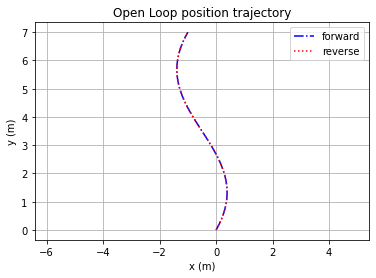

In [4]:
plt.plot(X_ol['fwd'][:,0],X_ol['fwd'][:,1], '-.b',label='forward') 
plt.plot(X_ol['rev'][:,0],X_ol['rev'][:,1], ':r',label='reverse')
plt.axis('equal')
plt.grid('major')
plt.legend()
plt.title('Open Loop position trajectory')
plt.xlabel('x (m)'); plt.ylabel('y (m)')
plt.show()

## Inspect the open-loop input trajectories 

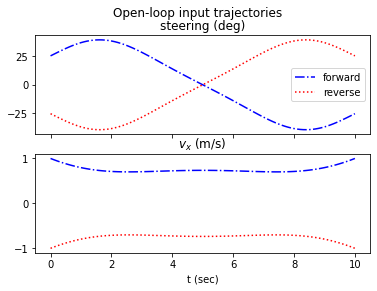

In [5]:
_, axs = plt.subplots(2,1,sharex=True)
plt.suptitle('Open-loop input trajectories')

axs[0].plot(t_eval, U_ol['fwd'][:,0]*180/np.pi, '-.b',label='forward') 
axs[0].plot(t_eval, U_ol['rev'][:,0]*180/np.pi, ':r',label='reverse')
axs[0].set_title('steering (deg)')
axs[0].legend()

axs[1].plot(t_eval, U_ol['fwd'][:,1], '-.b',label='forward') 
axs[1].plot(t_eval, U_ol['rev'][:,1], ':r',label='reverse')
axs[1].set_title('$v_x$ (m/s)')
axs[1].set_xlabel('t (sec)')
plt.show()

Notice that the speed is not exactly constant.

## Do we need feedback?

What the flatness-based trajectory generator assumes
* negligible actuator dynamics
* analog control
* negligible slip
* ...
* !!! The vehicle either drives forward or backward during the entire maneuver (being stationary results in singularity).

Let's see how bad it can get when each actuator has a (first-order) lag and the control is discretized with ZOH.

Notes on the simulation setup

1. You can easily switch to the reverse driving case. (see `change me`)
2. Regardless of driving in reverse of not, the simulation belows ensures the initial pose matches perfectly with the one used for generating the trajectory. And our initial pose is set based on the sign (see the beginning of this notebook)

What to try?
* driving in reverse (in that case, the plant is actually unstable so we shall expect close-loop control is more relevant.)
* concerning the 2 actuator-related state variables:
  
  * larger initial error in the steering wheel angle
  * larger initial error in the initial longitudinal velocity, maybe even the opposite polarity as the one used for generating the trajectory. 

In [6]:
mode_sim = 'fwd' # 'rev'  # <---- change me
X_ol_sim = X_ol[mode]
sgn_vx = +1 if mode_sim == 'fwd' else -1

from mrobotics.models.motion.simulator import kinematic_car_simulator
# state vector ordering (repeated from the docstring of kinematic_car_simulator)
# 0. X
# 1. Y
# 2. Yaw
# 3. actual steering angle
# 4. actual longitudinal velocity (a signed quantity!)
initial_state = np.array([*initial_pose[mode_sim], -np.pi/10, initial_speed*0.8*sgn_vx])
# initial_state = np.array([*initial_pose[mode_sim], -np.pi/4, 0.0]),  # <--- looking bad

# construct a simulator
plant_simulator = kinematic_car_simulator(
    step_sz=0.02, sim_duration=T_maneuver,  # 0.02 sec found to be sufficient (tried also 0.001 which leads to almost identical simulated trajectories)
    initial_state=initial_state,  
    wheelbase=wheelbase, tau_steering=0.1, tau_vx=0.5
)

In [7]:
def open_loop_control(sim_time):
    _, U = traj_generator.compute_traj_x_u(sim_time,vel_positive=(mode_sim=='fwd'))
    steering_angle_cmd, vx_cmd = U.T
    return float(steering_angle_cmd), float(vx_cmd)

In [8]:
while not plant_simulator.is_completed():
    sim_time = plant_simulator.get_current_time()
    steering_angle_cmd, vx_cmd = open_loop_control(sim_time)
    #--------------------------
    # must be called at the end of each step
    plant_simulator.step_actuate(steering_angle_cmd, vx_cmd)

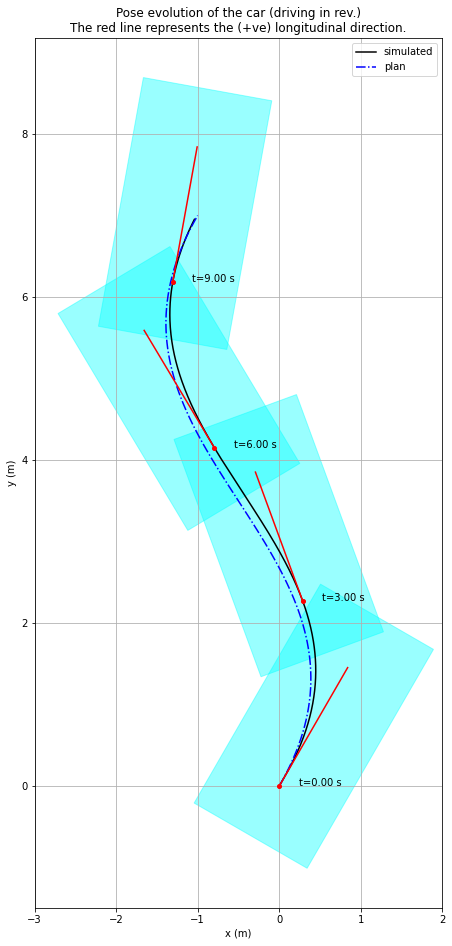

In [9]:
_,ax = plt.subplots(figsize=(12,16))
plant_simulator.viz_pose(ax=ax)
plt.plot(X_ol_sim[:,0],X_ol_sim[:,1], '-.b',label='plan') 
ax.legend()
ax.set_xlim([-3.0, 2.0])
ax.set_title(f"Pose evolution of the car (driving in {mode}.)\nThe red line represents the (+ve) longitudinal direction.")
for t in np.arange(0,T_maneuver, 3.0):
    ind = int( np.argwhere(plant_simulator.t_sim_ev >= t)[0] ) # show snapshot (roughly) by every 3.0 sec
    footprint.draw_pose(
        X    = plant_simulator.X[ind,0],
        Y    = plant_simulator.X[ind,1],
        theta= plant_simulator.X[ind,2], 
        ax=ax, show_x_axis=True
    )
    plt.text(
        plant_simulator.X[ind,0]+0.5, 
        plant_simulator.X[ind,1],
        f't={plant_simulator.t_sim_ev[ind]:2.2f} s',
        ha='center'
    )
plt.show()

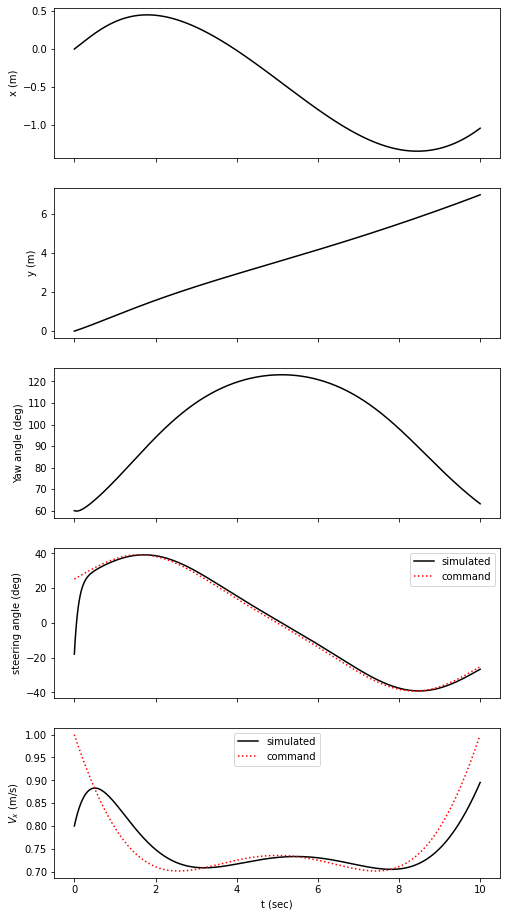

In [10]:
fig, axs = plt.subplots(5,1, sharex=True, figsize=(8,16))
plant_simulator.viz_trace(axs)
plt.show()

If the simulation model is representative enough (note that measurement noise, which we don't simulate, is irrelevant for any open-loop control), 
the open loop control looks acceptable in our test case.
However, we are just lucky. Most likely, you will see a different picture if you try to ...
* simulate with another initial state while keeping the offline trajectory unchanged (see the line with comment `looking bad`) and/or
* plan an offline (feasible) trajectory for a **longer** horizon 

In practice, we can apply feedback in form of trajectory tracker to "properly" execute the offline plan.

Another feedback approach can be re-generating the trajectory, say at regular "replanning" time interval (basically the same idea as MPC, although here we don't have any optimization for our cubic representation under the hood).
This might lead to improved system performance (which hasn't been defined yet ^.^) 
Replanning is more involved (How shall we "shape" the trajectory? For that we really need to clarify the intented behavior, e.g. changing lane in our example) so we shall leave for another day.

Both feedback approaches can be combined together.

Limitations of applying flatness to generating feasible trajectories for car-like vehicle.
1. It works well for large free workspace but it might make more sense to work directly in the (higher dimensional) state space if you have input and state constraints (e.g. collision avoidance).
2. You need to specify (externally) the sign of the longitudinal velocity. 
3. Say you want to reverse the sign of the velocity at time t=t2, you must generating separate trajectories for 0 --> t2 and t2 --> T. Notice that using the analytical expression, there will be singularity issue when the planned velocity == 0; my implementation has a small trick to avoid this. Nonetheless, it is **NOT recommended** to specify the start or terminal velocity to be a zero-vector (which can lead steering angle closed to +/- 90 deg).